#**Train model**

In [6]:
from google.colab import drive

# Kết nối với Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Remove folder**

In [7]:
!rm -rf "/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character"

In [8]:
!rm -rf "/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Model"

In [9]:
import os

# Điều chỉnh đường dẫn đến thư mục chứa tệp tin zip trên Google Drive
folder_path = '/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI'
os.chdir(folder_path)

**Extract Dataset Zip file**

In [10]:
import zipfile

# Tên tệp tin zip cần giải nén
zip_file_name = 'LP_Character.zip'

# Đường dẫn đến tệp tin zip
zip_file_path = os.path.join(folder_path, zip_file_name)

# Đường dẫn đến thư mục giải nén
extract_path = '/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI'

# Giải nén tệp tin zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
import os

# Đường dẫn đến thư mục giải nén
extracted_folder_path = '/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character'

# Đếm số lượng tệp tin trong thư mục giải nén
num_files = len([f for f in os.listdir(extracted_folder_path) if os.path.isfile(os.path.join(extracted_folder_path, f))])

# Xuất thông tin số lượng tệp tin
print(f"Số lượng tệp tin trong thư mục giải nén: {num_files}")


Số lượng tệp tin trong thư mục giải nén: 64145


In [11]:
!pip install scikit-learn

In [12]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2

In [13]:
%cd '/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI'

/content


In [14]:
data = pd.read_csv("LP_Char.csv",header=None)
X_orig = data.iloc[:,:-1]
y_orig = data.iloc[:,-1]
unique_classes, class_counts = np.unique(y_orig, return_counts=True)
print(len(unique_classes))
print(unique_classes)
print(class_counts)
print(X_orig.shape)
print(y_orig.shape)

32
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 25 26
 27 28 29 30 31 33 34 35]
[1924 1248 1617 1861 2241 1930 2009 1831 1947 2009 2839 2025 2200 2181
 2240 1664 1943 2210 2035 1582 2158 2472 2159 1752 2515 2361 1775 1985
 2064 2026 2011 1331]
(64145, 1)
(64145,)


In [15]:
char_width = 35
char_height = 50

In [16]:
def get_data(X):
  list_image = []
  image_folder = "/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/"
  for i in np.arange(X.shape[0]):
    filename = X.iloc[i].values[0]
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (char_width, char_height))
        print("read img:", image_path)
        list_image.append(image)
    else:
        print("Error reading img:", image_path)
  return list_image

In [17]:
def rotate(image):
    angle = np.random.randint(-30, 30, 1)[0]
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def shear(image):
    shear_factor = np.random.uniform(-0.2, 0.2)
    M = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

def threshold(image):
    # Apply a random threshold to the image
    _, image = cv2.threshold(image, np.random.uniform(50, 150), 255, cv2.THRESH_BINARY)
    return image

def adjust_contrast(image):
    # Apply random contrast adjustment to the image
    alpha = np.random.uniform(0.5, 1.5)
    return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

def Augmentation(image, k):
    if k == 0:
        image = rotate(image)
    elif k == 1:
        image = shear(image)
    elif k == 2:
        image = threshold(image)
    elif k == 3:
        image = adjust_contrast(image)
    # Add more conditions for other augmentation techniques as needed
    return image


In [18]:
# def rotate(image):
#     angle = np.random.randint(-30,30,1)[0]
#     (h, w) = image.shape[:2]
#     center = (w / 2, h / 2)
#     M = cv2.getRotationMatrix2D(center, angle, 1.0)
#     return cv2.warpAffine(image, M, (w, h))

# def shear(image):
#     shear_factor = np.random.uniform(-0.2, 0.2)
#     M = np.float32([[1, shear_factor, 0],[0, 1, 0]])
#     return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

# def Augmentation(image, k):
#     if k == 0:
#         image = rotate(image)
#     if k == 1:
#         image = shear(image)
#     return image


In [19]:
X_temp = get_data(X_orig)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1256).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1257).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1258).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1259).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (126).png
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1260).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1261).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1262).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1263).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1264).jpg
read img: /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Character/33 (1265).jpg
read img: /content/drive/MyDrive/DO_AN_CHU

In [20]:
print(X_orig.shape)
print(y_orig.shape)
print(len(X_temp))

(64145, 1)
(64145,)
64145


In [21]:
def Data_Augmentation(X_temp, y_orig, num_transforms =5 ):
  # list_image = get_data(X_orig) #  ==> List
  num_method = 4
  list_image2array = np.array(X_temp) #Danh sach anh
  list_image_copy = X_temp.copy()
  y_copy= list(np.copy(y_orig))
  for i in range(num_transforms):
    print(i+1)
    for j in range(list_image2array.shape[0]): #Với mỗi ảnh sẽ
      for k in range(num_method): #thực hiện 2 phương pháp augmentation: rotate và shear
        list_image_copy.append(Augmentation(list_image2array[j,:], k)) #thêm ảnh vừa transform vào L2
        y_copy.append(y_orig[j]) #Thêm nhãn tương ứng

  return np.array(list_image_copy), np.array(y_copy)


In [27]:
X_train_final, y_train_final = Data_Augmentation(X_temp, y_orig, num_transforms=3)
print(X_train_final.shape)
print(y_train_final.shape)

1
2
3
(833885, 50, 35)
(833885,)


In [29]:
print(X_train_final[0])
print(y_train_final[0])

[[121 121 121 ... 115 115 115]
 [121 121 121 ... 114 116 113]
 [120 120 120 ... 114 114 113]
 ...
 [136 135 135 ... 132 134 135]
 [136 136 136 ... 126 124 125]
 [136 136 136 ... 134 132 130]]
0


In [32]:
def random_sample(X, y, sample_size=10):
    # Lấy ngẫu nhiên indices
    random_indices = np.random.choice(len(X), size=sample_size, replace=False)

    # Lấy các giá trị tương ứng từ X và y
    sampled_X = X[random_indices]
    sampled_y = y[random_indices]

    return sampled_X, sampled_y

In [33]:
label_str ="0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z"
img_label = np.array(label_str.split())
print(len(img_label))

36


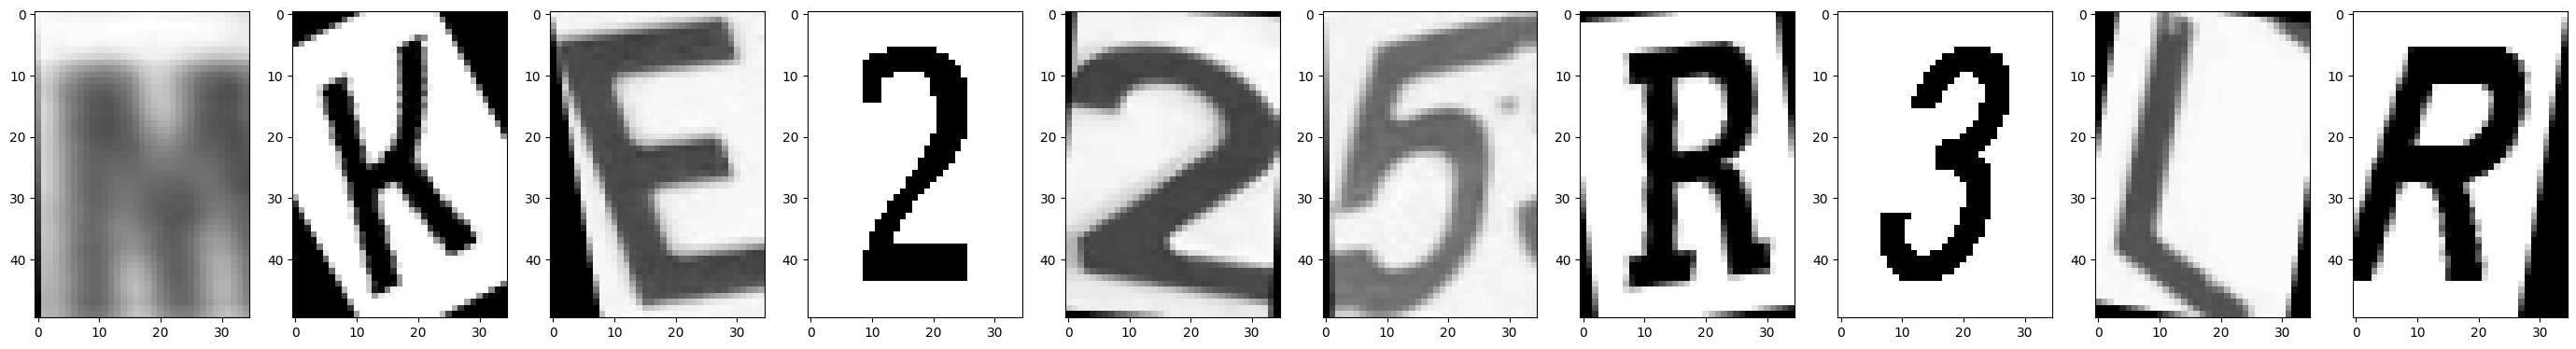

M
K
E
2
2
5
R
3
L
R


In [34]:
def show_char(chartest):
    fig, axs = plt.subplots(nrows=1, ncols=len(chartest), figsize=(35,50))
    for i in range(len(chartest)):
      ax = axs[i]
      ax.imshow(chartest[i], cmap='gray')
    plt.show()
chartest, label = random_sample(X_train_final, y_train_final)
show_char(chartest)
for i in range(len(label)):
  print(img_label[label[i]])

###**VGG16-V1**



In [35]:
num_class = 36

In [36]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

def Build_VGG16():
  model = Sequential()
  model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv1', input_shape=(char_height, char_width, 1)))
  model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv2'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_maxpool'))

  model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv1'))
  model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv2'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_maxpool'))

  model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv1'))
  model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv2'))
  model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv3'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_maxpool'))

  model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv1'))
  model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv2'))
  model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv3'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block4_maxpool'))

  model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv1'))
  model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv2'))
  model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv3'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block5_maxpool'))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dropout(0.5))
  model.add(Dense(num_class, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Reduce learning rate on plateau
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

  # Early stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)

  model.summary()
  return model


In [37]:
VGG16 = Build_VGG16()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 50, 35, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 35, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 50, 35, 64)        256       
 Normalization)                                                  
                                                                 
 block1_maxpool (MaxPooling  (None, 25, 17, 64)        0         
 2D)                                                             
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 17, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 17, 128)       1

###**VGG19**

In [ ]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)

def Build_VGG19():
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv1', input_shape=(char_height, char_width, 1)))
    model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_maxpool'))

    model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv1'))
    model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_maxpool'))

    model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv1'))
    model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv2'))
    model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv3'))
    model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_maxpool'))

    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv1'))
    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv2'))
    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv3'))
    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block4_maxpool'))

    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv1'))
    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv2'))
    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv3'))
    model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block5_maxpool'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))

    # Compile the model
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    model.summary()
    return model


In [ ]:
VGG19 = Build_VGG19()

In [38]:
def Compression():
  !zip -ru LP_Model.zip /content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Model

In [39]:
import matplotlib.pyplot as plt

In [42]:
def Train_VGG(model, X_temp, y_orig, iters=5, num_epochs = 10, _batch_size = 1024, model_name="LP_Model"):
  for i in range(iters):
    print(f"------------------------{i+1}------------------------")
    X_train_final, y_train_final = Data_Augmentation(X_temp, y_orig, num_transforms=3)
    X_train, X1, y_train, y1 = train_test_split(X_train_final, y_train_final, test_size=0.05, random_state=42)
    X_dev, X_test, y_dev, y_test = train_test_split(X1, y1, test_size=0.5, random_state=42)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_dev shape: {X_dev.shape}")
    print(f"X_test shape: {X_test.shape}")

    # Training on the training set
    history = model.fit(X_train, y_train, batch_size=_batch_size, epochs=num_epochs, validation_data=(X_dev, y_dev))
    model.save(f"{model_name}.h5")

    # Compression()

    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    y_pred = model.predict(X_test)
    yy_pred=np.argmax(y_pred,axis=1)
    print(accuracy_score(y_test, yy_pred))

    # Print training and validation loss over epochs
    for epoch, (loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss'])):
        print(f'Epoch {epoch + 1}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}')


    # Optionally, plot the training loss and validation loss over epochs
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


------------------------1------------------------
1
2
3
X_train shape: (792190, 50, 35)
X_dev shape: (20847, 50, 35)
X_test shape: (20848, 50, 35)
Epoch 1/5
774/774 [==============================] - 534s 644ms/step - loss: 1.6673 - accuracy: 0.8472 - val_loss: 0.2770 - val_accuracy: 0.9569
Epoch 2/5
774/774 [==============================] - 473s 611ms/step - loss: 0.1951 - accuracy: 0.9737 - val_loss: 0.1913 - val_accuracy: 0.9721
Epoch 3/5
774/774 [==============================] - 471s 609ms/step - loss: 0.3231 - accuracy: 0.9735 - val_loss: 0.1329 - val_accuracy: 0.9785
Epoch 4/5
774/774 [==============================] - 469s 606ms/step - loss: 0.3219 - accuracy: 0.9697 - val_loss: 0.1649 - val_accuracy: 0.9728
Epoch 5/5
774/774 [==============================] - 465s 600ms/step - loss: 0.1313 - accuracy: 0.9781 - val_loss: 0.1261 - val_accuracy: 0.9783


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


652/652 [==============================] - 9s 12ms/step - loss: 0.1269 - accuracy: 0.9790
Test accuracy: 0.9790387749671936
Test loss: 0.12688344717025757
652/652 [==============================] - 6s 9ms/step
0.9790387567152724
Epoch 1, Training Loss: 1.6673, Validation Loss: 0.2770
Epoch 2, Training Loss: 0.1951, Validation Loss: 0.1913
Epoch 3, Training Loss: 0.3231, Validation Loss: 0.1329
Epoch 4, Training Loss: 0.3219, Validation Loss: 0.1649
Epoch 5, Training Loss: 0.1313, Validation Loss: 0.1261


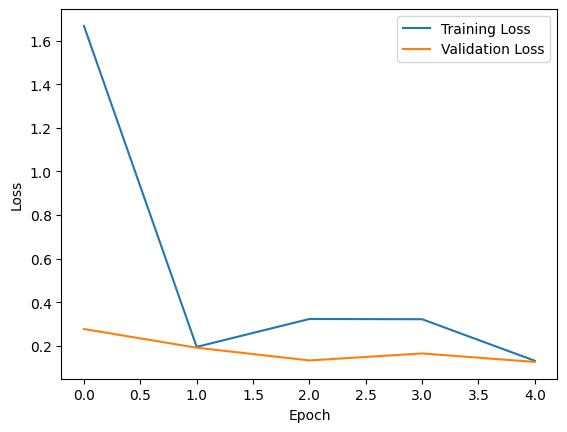

------------------------2------------------------
1
2
3


In [ ]:
Train_VGG(VGG16, X_temp, y_orig, iters=3, num_epochs = 5, _batch_size = 1024, model_name="VGG16Modelv16")

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/VGG16Modelv16.h5')

In [ ]:
# Train_VGG(VGG19, X_temp, y_orig, iters=3, num_epochs = 5, _batch_size = 1024, model_name="VGG19Modelv16")

In [ ]:
# #export your model's weights for future use
# from google.colab import files
# files.download('/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/VGG19Modelv16.h5')

In [ ]:
# # %cd '/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI'
# !cp -rfv '/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI/LP_Model' '/content/drive/MyDrive'

#Test model

In [ ]:
X_train_final, y_train_final = Data_Augmentation(X_temp, y_orig, num_transforms=5)
X_train, X1, y_train, y1 = train_test_split(X_train_final, y_train_final, test_size=0.05, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X1, y1, test_size=0.5, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"X_test shape: {X_test.shape}")

In [ ]:
import keras
ReadChar_model = keras.models.load_model("/content/LP_Modelv13.h5")

In [ ]:
from sklearn.metrics import accuracy_score
def recognition_by_path(model, X_test):
  label_str ="0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z"
  img_label = np.array(label_str.split())
  char_width = 35
  char_height = 50
  listChar = []
  for i in range(len(X_test)):
      image_resize = cv2.resize(X_test[i], (char_width, char_height)) #w, h
      prep = model.predict(image_resize.reshape(1,char_height,char_width,1))
      predicted_class = np.argmax(prep)
      predicted_label = label_str[predicted_class]
      listChar.append(predicted_class)
  return listChar

def compute_accuracy(model, X_test, y_test):
    # Dự đoán kết quả trên tập x_test
    pre_set = X_test
    predictions = recognition_by_path(model, pre_set)

    # Tính toán độ chính xác
    y_test_set = y_test
    accuracy = accuracy_score(y_test_set, predictions)

    return accuracy

In [ ]:
X2 = X_test[0:10]
res = recognition_by_path(ReadChar_model, X2)
print(res)

In [ ]:
# label_str ="0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z"
# img_label = np.array(label_str.split())
# char_width = 35
# char_height = 50
# print(X_test[0])
# image_resize = cv2.resize(X_test[0], (char_width, char_height)) #w, h
# prep = ReadChar_model.predict(image_resize.reshape(1,char_height,char_width,1))
# predicted_class = np.argmax(prep)
# predicted_label = label_str[predicted_class]
# print(predicted_label)

In [ ]:
acc = compute_accuracy(ReadChar_model,  X_test, y_test)
print(f"Accuracy: {acc * 100}%")


In [ ]:
print(X_test.shape)
print(y_test.shape)

#**TF to onnx**

In [ ]:
# !pip install tf2onnx
# !pip install onnxruntime
# !pip install onnx

In [ ]:
# %cd '/content/drive/MyDrive/DO_AN_CHUYEN_NGANH_AI'

In [ ]:
# import tensorflow as tf
# import tf2onnx
# import onnxruntime as ort
# import onnx

# # Load model from the saved directory
# model = tf.keras.models.load_model('LP_Model19')

In [ ]:
# import cv2
# from PIL import Image

# sess = ort.InferenceSession("/content/drive/MyDrive/LP_Model.onnx", providers=["CUDAExecutionProvider","CPUExecutionProvider"])

# input_name= "block1_conv1_input"
# output_name="dense_5"

# image = Image.open('/content/5.png')
# image_array = cv2.imread('/content/5.png')
# image_array=cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
# print(image_array.shape)
# image_array=cv2.resize(image_array, (35,50))
# print(image_array.shape)
# plt.imshow(image_array, cmap = 'gray')
# input=image_array.reshape(1,50,35,1).astype(np.float32)

# prep = sess.run([output_name], {input_name: input})
# print(prep)
# print(np.argmax(prep))
# print(img_label[np.argmax(prep)])

#*LP PREPROCESSING*

In [ ]:
# !pip install pytesseract

In [ ]:
# import cv2
# import numpy as np
# import pytesseract
# from pytesseract import Output
# import argparse

# # #construct the argument parser and parse the arguments
# # ap = argparse.ArgumentParser()
# # ap.add_argument("-i", "--image", required=True,
# # 	help="path to input image")
# # ap.add_argument("-c", "--connectivity", type=int, default=4,
# # 	help="connectivity for connected component analysis")
# # args = vars(ap.parse_args())

# class ImgToCharByORC:
#     def __init__(self,path = "C:/Program Files/Tesseract-OCR/tesseract.exe"):
#         self.path = path
#         pass
#     # get grayscale image
#     def get_grayscale(self,image):
#         return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # noise removal
#     def remove_noise(self,image):
#         return cv2.medianBlur(image,5)

#     #Gaussian filtering
#     def gaussian_filter(self,img):
#         return cv2.GaussianBlur(img,(5,5),0)

#     #thresholding
#     def thresholding(self,image):
#         return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#     #thresholding inv
#     def thresholding_inv(self,image):
#         return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     #adaptiveThreshold
#     def adaptiveThreshold(self,image):
#         return cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

#     #dilation
#     def dilate(self,image):
#         kernel = np.ones((5,5),np.uint8)
#         return cv2.dilate(image, kernel, iterations = 1)

#     #erosion
#     def erode(self,image):
#         kernel = np.ones((5,5),np.uint8)
#         return cv2.erode(image, kernel, iterations = 1)

#     #opening - erosion followed by dilation
#     def opening(self,image):
#         kernel = np.ones((5,5),np.uint8)
#         return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#     #canny edge detection
#     def canny(self,image):
#         return cv2.Canny(image, 100, 200)

#     #skew correction
#     def deskew(self,image):
#         coords = np.column_stack(np.where(image > 0))
#         angle = cv2.minAreaRect(coords)[-1]
#         if angle < -45:
#             angle = -(90 + angle)
#         else:
#             angle = -angle
#         (h, w) = image.shape[:2]
#         center = (w // 2, h // 2)
#         M = cv2.getRotationMatrix2D(center, angle, 1.0)
#         rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
#         return rotated

#     #template matching
#     def match_template(self,image, template):
#         return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
#     def ToStr(self,image):
#         pytesseract.pytesseract.tesseract_cmd=self.path
#         # Adding custom options
#         custom_config = r'--oem 3 --psm 11'
#         return pytesseract.image_to_string(image=image, config=custom_config)

In [ ]:
# import matplotlib.pyplot as plt
# import cv2
# image = cv2.imread('test_img/bs.jpg')
# image = cv2.resize(image, (300, 300))
# orc=ImgToCharByORC()
# gray = orc.get_grayscale(image)
# gray =orc.remove_noise(gray)
# gaus = orc.gaussian_filter(gray)
# thres_inv = orc.thresholding_inv(gaus)

# plt.imshow(thres_inv, cmap="gray")

# connectivity = 4 #4 or 8

# output = cv2.connectedComponentsWithStats(
# 	thres_inv, connectivity , cv2.CV_32S)
# (numLabels, labels, stats, centroids) = output

# print("numLabels",numLabels)
# print("labels",labels)
# print("stats",stats)
# print("centroids",centroids)

In [ ]:
# # loop over the number of unique connected component labels
# x,y,w,h,cX,cY=0,0,0,0,0,0
# image_copy = image.copy()
# for i in range(0, numLabels):
# 	# if this is the first component then we examine the
# 	# *background* (typically we would just ignore this
# 	# component in our loop)
# 	if i == 0:
# 		text = "examining component {}/{} (background)".format(
# 			i + 1, numLabels)
# 	# otherwise, we are examining an actual connected component
# 	else:
# 		text = "examining component {}/{}".format( i + 1, numLabels)
# 	# print a status message update for the current connected
# 	# component
# 	print("[INFO] {}".format(text))
# 	# extract the connected component statistics and centroid for
# 	# the current label
# 	x = stats[i, cv2.CC_STAT_LEFT]
# 	y = stats[i, cv2.CC_STAT_TOP]
# 	w = stats[i, cv2.CC_STAT_WIDTH]
# 	h = stats[i, cv2.CC_STAT_HEIGHT]
# 	area = stats[i, cv2.CC_STAT_AREA]
# 	(cX, cY) = centroids[i]

# 	# clone our original image (so we can draw on it) and then draw
# 	# a bounding box surrounding the connected component along with
# 	# a circle corresponding to the centroid

# 	cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 3)
# 	cv2.circle(image_copy, (int(cX), int(cY)), 4, (0, 0, 255), -1)


In [ ]:
# # construct a mask for the current connected component by
# # finding a pixels in the labels array that have the current
# # connected component ID
# componentMask = (labels == 1).astype("uint8") * 255
# # show connected component mask
# cv2.imshow("Connected Component "+str(i), componentMask)
# #show output image
# cv2.imshow("Output", image_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# # initialize an output mask to store all characters parsed from
# # the license plate
# mask = np.zeros(gray.shape, dtype="uint8")

# # loop over the number of unique connected component labels, skipping
# # over the first label (as label zero is the background)
# x,y,w,h,cX,cY=0,0,0,0,0,0
# image_copy = image.copy()
# for i in range(1, numLabels):
# 	# extract the connected component statistics for the current
# 	# label
# 	x = stats[i, cv2.CC_STAT_LEFT]
# 	y = stats[i, cv2.CC_STAT_TOP]
# 	w = stats[i, cv2.CC_STAT_WIDTH]
# 	h = stats[i, cv2.CC_STAT_HEIGHT]
# 	area = stats[i, cv2.CC_STAT_AREA]
# 	(cX, cY) = centroids[i]

# 	# ensure the width, height, and area are all neither too small
# 	# nor too big
# 	keepWidth = w >= 20 and w <= 80
# 	keepHeight = h >= 20 and h < 200
# 	keepArea = area >= 1000 and area <= 4000
# 	# ensure the connected component we are examining passes all
# 	# three tests
# 	if all((keepWidth, keepHeight, keepArea)):
# 		# construct a mask for the current connected component and
# 		# then take the bitwise OR with the mask
# 		print("[INFO] keeping connected component '{}'".format(i))
# 		componentMask = (labels == i).astype("uint8") * 255
# 		mask = cv2.bitwise_or(mask, componentMask)
# 	# clone our original image (so we can draw on it) and then draw
# 	# a bounding box surrounding the connected component along with
# 	# a circle corresponding to the centroid

# # show the original input image and the mask for the license plate
# # characters
# cv2.imshow("Image", image)
# cv2.imshow("Characters", mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from ultralytics import YOLO
# import torch
# import tensorflow as tf
# import easyocr
# import onnxruntime as ort

# class SpiltCharacter():
#     def __init__(self, image,detail=True, connectivity=4,frame_crop=0):
#         self.image = image
#         self.detail =detail
#         self.connectivity = connectivity  # 4 or 8
#         self.frame_crop = frame_crop

#     # get grayscale image
#     def get_grayscale(self, image):
#         return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # noise removal
#     def remove_noise(self, image):
#         return cv2.medianBlur(image, 5)

#     # Gaussian filtering
#     def gaussian_filter(self, img):
#         return cv2.GaussianBlur(img, (5, 5), 0)

#     # thresholding inv
#     def thresholding_inv(self, image):
#         return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     def Connected(self, thres_inv):
#         return cv2.connectedComponentsWithStats(thres_inv, self.connectivity, cv2.CV_32S)

#     def Sort_stats_for_y(self,stats):
#         min_y= np.min(stats[:,1])
#         min_y*=3

#         #bien 1 dong
#         if np.sum(stats[:,1]>min_y)>5:
#             for i in range(len(stats)-1):
#                 for j in range(i+1,len(stats)):
#                     if stats[i,0] > stats[j,0]:
#                         stats[[i,j],:] = stats[[j,i],:]
#         else:   # bien 2 dong
#             for i in range(len(stats)-1):
#                 for j in range(i+1,len(stats)):
#                     if stats[i,1] <= min_y and stats[j,1] <=min_y:
#                         if stats[i,0] > stats[j,0]:
#                             stats[[i,j],:] = stats[[j,i],:]
#                     elif stats[i,1] > min_y and stats[j,1] > min_y:
#                         if stats[i,0] > stats[j,0]:
#                             stats[[i,j],:] = stats[[j,i],:]
#         return stats
#     def Split(self, wl =[20,200], hl=[20,200], areal=[500,4000]):
#         gay = self.get_grayscale(self.image)
#         remove_noise = self.remove_noise(gay)
#         gaus = self.gaussian_filter(remove_noise)
#         thresh_inv = self.thresholding_inv(gaus)
#         (numLabels, labels, stats, centroids) = self.Connected(thresh_inv)
#         # loop over the number of unique connected component labels, skipping
#         # over the first label (as label zero is the background)
#         # stats=self.Sort_stats_for_y(stats)
#         stats_sort =[]
#         image_split=[]
#         for i in range(1, numLabels):
#             # extract the connected component statistics for the current
#             # label
#             x = stats[i, cv2.CC_STAT_LEFT]
#             y = stats[i, cv2.CC_STAT_TOP]
#             w = stats[i, cv2.CC_STAT_WIDTH]
#             h = stats[i, cv2.CC_STAT_HEIGHT]
#             area = stats[i, cv2.CC_STAT_AREA]
#             (cX, cY) = centroids[i]

#             # ensure the width, height, and area are all neither too small
#             # nor too big
#             keepWidth =  w >= wl[0] and w <= wl[1]
#             keepHeight = h >= hl[0] and h <= hl[1]
#             keepArea = area >= areal[0] and area <= areal[1]
#             # ensure the connected component we are examining passes all
#             # three tests
#             if all((keepWidth, keepHeight, keepArea)):
#                 # construct a mask for the current connected component and
#                 # then take the bitwise OR with the mask
#                 #print("[INFO] keeping connected component '{}'".format(i))
#                 #componentMask = (labels == i).astype("uint8") * 255
#                 #mask = cv2.bitwise_or(mask, componentMask)
#                 stats_sort.append(stats[i,:])
#         if len(stats_sort) == 0 :return []
#         stats_sort=self.Sort_stats_for_y(np.array(stats_sort))
#         if self.detail:
#             print(stats)
#             print(stats_sort)
#         for i in range(stats_sort.shape[0]):
#             x = stats_sort[i, cv2.CC_STAT_LEFT]
#             y = stats_sort[i, cv2.CC_STAT_TOP]
#             w = stats_sort[i, cv2.CC_STAT_WIDTH]
#             h = stats_sort[i, cv2.CC_STAT_HEIGHT]
#             area = stats_sort[i, cv2.CC_STAT_AREA]
#             image_split.append(self.image[y-self.frame_crop:y+h+self.frame_crop,x-self.frame_crop:x+w+self.frame_crop])
#         return image_split

# class PredictChacracterByCNN:
#     def __init__(self,path="ktbienso.onnx",):
#         self.model_character =  ort.InferenceSession("ktbienso.onnx", providers=["CUDAExecutionProvider","CPUExecutionProvider"])
#         self.image_label= np.array("0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z".split())
#     def Predict(self,image):
#         input_name= "block1_conv1_input"
#         output_name="dense_5"
#         image_resize=cv2.resize(image, (35,50))
#         image_gray=cv2.cvtColor(image_resize, cv2.COLOR_BGR2GRAY)
#         image_array = np.asarray(image_gray)
#         prep = self.model_character.run([output_name], {input_name:image_array.reshape(1,50,35,1).astype(np.float32)})
#         return self.image_label[np.argmax(prep)]
#     def PredictListImage(self,list_image):
#         pred_str=''
#         for i in list_image:
#             pred_str+=self.Predict(i)
#         return pred_str

# class PredictChacracterByPytesserac:
#     def __init__(self,path = "C:/Program Files/Tesseract-OCR/tesseract.exe"):
#         self.path = path

#     def Predict(self,image,ome =3 ,psm =6,lang='eng'):
#         # image_resize=cv2.resize(image, (50,35))
#         image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         remove_noise = cv2.medianBlur(image_gray, 5)
#         gaus = cv2.GaussianBlur(remove_noise, (5, 5), 0)
#         thres_inv=cv2.threshold(gaus, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#         pytesseract.pytesseract.tesseract_cmd=self.path
#         # Adding custom options
#         custom_config = r'--oem '+str(ome) +' --psm '+str(psm) +' -c tessedit_char_whitelist=0123456789ABCDEFHIJKLMNPQRSTUVWXYZG'
#         return pytesseract.image_to_string(image=thres_inv, config=custom_config,lang=lang)
#     def PredictListImage(self,list_image,ome =3 ,psm =6):
#         pred_str=''
#         for i in list_image:
#             pred_str+=self.Predict(i,ome=ome,psm=psm)
#         return pred_str

# class PredictChacracterByEasyocr:
#     def __init__(self,lang = ['en'],gpu=True):
#         self.reader = easyocr.Reader(lang,gpu=gpu)

#     def Predict(self,image,ome =3 ,psm =6):
#         # image_resize=cv2.resize(image, (50,35))
#         image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         result = self.reader.readtext(image_gray,detail = 0)
#         if len(result) > 0: return result[0]
#         else: return ""
#     def PredictListImage(self,list_image):
#         pred_str=''
#         for i in list_image:
#             pred_str+=self.Predict(i)
#         return pred_str

# class YoloPredict:
#     def __init__(self, yolo_path="yolov8/bienso/best.pt", detail=True,accuracy=0.8, cnn=True, ocr=False, gpu_ocr=True):
#         self.model_yolo = YOLO(yolo_path)
#         self.preddict_cnn = PredictChacracterByCNN("ktbienso.onnx",)
#         self.preddict_ocr = PredictChacracterByEasyocr(['en'],gpu=gpu_ocr)
#         self.cnn = cnn
#         self.ocr = ocr
#         self.detail = detail
#         self.accuracy=accuracy
#     def Predict(self, image):
#         results = self.model_yolo(image)  # predict on an image
#         result = results[0]
#         boxes = result.boxes  # Boxes object for bbox outputs
#         name_str = result.names[0]
#         license_plate = []
#         license_plate_img = []
#         for i in np.arange(len(boxes.boxes)):
#             if boxes.boxes[i,-2] >= self.accuracy:
#                 xy = np.array(torch.Tensor.cpu(boxes.xyxy[i, 0:2])).astype(int)
#                 xy2 = np.array(torch.Tensor.cpu(boxes.xyxy[i, 2:4])).astype(int)
#                 crop_img = image[xy[1]:xy2[1], xy[0]:xy2[0]]
#                 crop_img_resize = cv2.resize(crop_img, (300, 300))
#                 license_plate_img.append(crop_img_resize)
#                 split = SpiltCharacter(crop_img_resize,self.detail,frame_crop=10)
#                 image_split = split.Split(wl=[10, 300], hl=[50, 300], areal=[500, 4000])
#                 if len(image_split) == 0:
#                     continue
#                 if self.cnn :
#                     license_plate.append(self.preddict_cnn.PredictListImage(image_split))
#                 if self.ocr :
#                     license_plate.append(self.preddict_ocr.PredictListImage(image_split))
#         return results[0].plot(), license_plate,license_plate_img
